In [16]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import torchvision.models as models
import  matplotlib.pyplot as plt

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Load the Data 

In [23]:
image_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast= 0.2),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std = [0.229,0.224, 0.225])
])

In [24]:
dataset_path = "/Users/sudiptapriyamkakoty/Documents/Deep_Learning_Project/training/dataset"
dataset = datasets.ImageFolder(root = dataset_path, transform = image_transform )
len(dataset)

2300

In [85]:
class_names= dataset.classes

In [26]:
num_classes = len(dataset.classes)
print(num_classes)

6


## Train Test Split

In [30]:
train_size = int(0.75 *len(dataset))
val_size = len(dataset) - train_size

train_size, val_size

(1725, 575)

In [32]:
from torch.utils.data import random_split

train_dataset, val_dataset= random_split(dataset,[train_size, val_size])

In [33]:
train_loader = DataLoader(train_dataset,  batch_size= 32, shuffle=True)
val_loader = DataLoader(val_dataset,  batch_size= 32, shuffle=True)

In [34]:
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])


In [43]:
images[4].shape
labels[4]

tensor(5)

In [38]:
images[0].permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9254032].


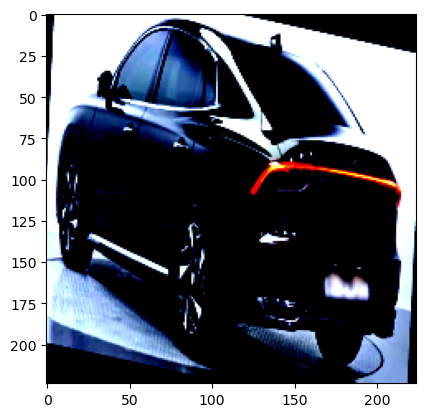

In [42]:
plt.imshow(images[4].permute(1,2,0))
plt.show()

### Model 1: Convolutional Neural Network 

In [ ]:
class CarClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), #(16,224,224)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #(16, 112, 112)

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), #(32,112,112)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #(32,56,56)

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1), #(64,56,56)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #(64,28,28)
            nn.Flatten(),
            nn.Linear(64*28*28, 512),
            nn.ReLU(),  # Fixed: added parentheses here
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.network(x)

model = CarClassifierCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [66]:
def train_model(model, criterion, optimizer, epochs=5):
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0  # Initialize running_loss
        
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Print batch-wise loss
            if (batch_num + 1) % 10 == 0:
                print(f"Batch: {batch_num + 1}, Epoch: {epoch + 1}, Loss: {loss.item():.2f}")

            running_loss += loss.item() * images.size(0)

        # Calculate epoch loss
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch + 1}/{epochs}], Avg Loss: {epoch_loss:.4f}")

    # Validation
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []  # Fixed typo (was 'all_prediction')

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()  # Fixed: .item() instead of .items()
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Print final validation accuracy (outside the loop)
    val_accuracy = 100 * correct / total
    print(f'Validation Accuracy: {val_accuracy:.2f}%')

    end = time.time()
    print(f"Execution time: {end - start:.2f} seconds")
    
    return all_labels, all_predictions

In [57]:
values, indices = torch.max(torch.tensor([[10,12,15,9,2]]),1)
values, indices

(tensor([15]), tensor([2]))

In [68]:
all_labels, all_predictions = train_model(model, criterion, optimizer, epochs=5)

Batch: 10, Epoch: 1, Loss: 1.38
Batch: 20, Epoch: 1, Loss: 1.43
Batch: 30, Epoch: 1, Loss: 1.21
Batch: 40, Epoch: 1, Loss: 1.26
Batch: 50, Epoch: 1, Loss: 1.32
Epoch [1/5], Avg Loss: 1.3901
Batch: 10, Epoch: 2, Loss: 0.97
Batch: 20, Epoch: 2, Loss: 1.40
Batch: 30, Epoch: 2, Loss: 1.19
Batch: 40, Epoch: 2, Loss: 1.55
Batch: 50, Epoch: 2, Loss: 1.19
Epoch [2/5], Avg Loss: 1.2331
Batch: 10, Epoch: 3, Loss: 1.12
Batch: 20, Epoch: 3, Loss: 1.16
Batch: 30, Epoch: 3, Loss: 0.86
Batch: 40, Epoch: 3, Loss: 1.15
Batch: 50, Epoch: 3, Loss: 1.14
Epoch [3/5], Avg Loss: 1.1030
Batch: 10, Epoch: 4, Loss: 1.22
Batch: 20, Epoch: 4, Loss: 0.95
Batch: 30, Epoch: 4, Loss: 0.99
Batch: 40, Epoch: 4, Loss: 1.01
Batch: 50, Epoch: 4, Loss: 0.87
Epoch [4/5], Avg Loss: 1.0142
Batch: 10, Epoch: 5, Loss: 1.06
Batch: 20, Epoch: 5, Loss: 1.06
Batch: 30, Epoch: 5, Loss: 1.14
Batch: 40, Epoch: 5, Loss: 0.96
Batch: 50, Epoch: 5, Loss: 0.82
Epoch [5/5], Avg Loss: 0.9411
Validation Accuracy: 56.35%
Execution time: 209.56

## Using Pretrained Model 

### Model 2: Efficient Net

In [72]:
model = models.efficientnet_b0(weights='DEFAULT')
model.classifier[1].in_features

1280

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

class CarClassifierEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Load pre-trained EfficientNet-B0
        self.model = models.efficientnet_b0(weights='DEFAULT')
        
        # Freeze all layers initially
        for param in self.model.parameters():
            param.requires_grad = False  # Fixed typo (was 'reuires_grad')
        
        # Get the number of input features for the classifier
        in_features = self.model.classifier[1].in_features  # Works for torchvision >= 0.11
        
        # Replace the classifier head
        self.model.classifier = nn.Sequential(
            nn.Dropout(p=0.2),  # EfficientNet typically uses dropout=0.2
            nn.Linear(in_features, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

# Initialize model, loss, and optimizer
model = CarClassifierEfficientNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),  # Fixed: requires_grad (no parentheses)
    lr=0.001
)

# Train the model
train_model(model, criterion, optimizer, epochs=5)


Batch: 10, Epoch: 1, Loss: 1.63
Batch: 20, Epoch: 1, Loss: 1.59
Batch: 30, Epoch: 1, Loss: 1.38
Batch: 40, Epoch: 1, Loss: 1.22
Batch: 50, Epoch: 1, Loss: 1.31
Epoch [1/5], Avg Loss: 1.4313
Batch: 10, Epoch: 2, Loss: 1.08
Batch: 20, Epoch: 2, Loss: 1.06
Batch: 30, Epoch: 2, Loss: 0.95
Batch: 40, Epoch: 2, Loss: 0.95
Batch: 50, Epoch: 2, Loss: 0.97
Epoch [2/5], Avg Loss: 1.0505
Batch: 10, Epoch: 3, Loss: 1.10
Batch: 20, Epoch: 3, Loss: 0.90
Batch: 30, Epoch: 3, Loss: 0.97
Batch: 40, Epoch: 3, Loss: 1.00
Batch: 50, Epoch: 3, Loss: 1.04
Epoch [3/5], Avg Loss: 0.9470
Batch: 10, Epoch: 4, Loss: 0.81
Batch: 20, Epoch: 4, Loss: 0.75
Batch: 30, Epoch: 4, Loss: 0.89
Batch: 40, Epoch: 4, Loss: 0.87
Batch: 50, Epoch: 4, Loss: 1.04
Epoch [4/5], Avg Loss: 0.8823
Batch: 10, Epoch: 5, Loss: 0.82
Batch: 20, Epoch: 5, Loss: 0.88
Batch: 30, Epoch: 5, Loss: 0.76
Batch: 40, Epoch: 5, Loss: 0.83
Batch: 50, Epoch: 5, Loss: 0.75
Epoch [5/5], Avg Loss: 0.8213
Validation Accuracy: 66.09%
Execution time: 542.25

([5,
  1,
  4,
  5,
  2,
  5,
  1,
  2,
  0,
  2,
  2,
  4,
  4,
  1,
  4,
  5,
  1,
  4,
  2,
  4,
  5,
  2,
  5,
  1,
  5,
  4,
  5,
  1,
  1,
  3,
  2,
  2,
  5,
  0,
  5,
  2,
  2,
  5,
  5,
  5,
  4,
  5,
  1,
  2,
  1,
  0,
  3,
  2,
  4,
  4,
  1,
  1,
  5,
  2,
  3,
  2,
  3,
  4,
  2,
  2,
  4,
  1,
  5,
  0,
  2,
  2,
  2,
  3,
  2,
  2,
  1,
  2,
  0,
  1,
  3,
  2,
  0,
  1,
  0,
  0,
  2,
  1,
  4,
  0,
  0,
  1,
  0,
  3,
  1,
  2,
  3,
  2,
  3,
  1,
  0,
  2,
  4,
  3,
  0,
  5,
  1,
  1,
  1,
  4,
  1,
  0,
  4,
  0,
  5,
  3,
  4,
  0,
  2,
  3,
  5,
  1,
  3,
  0,
  1,
  0,
  5,
  0,
  3,
  3,
  5,
  4,
  5,
  1,
  2,
  0,
  0,
  2,
  0,
  2,
  4,
  4,
  2,
  0,
  3,
  1,
  4,
  1,
  0,
  3,
  5,
  1,
  0,
  0,
  2,
  1,
  1,
  0,
  4,
  5,
  3,
  3,
  5,
  1,
  5,
  0,
  5,
  0,
  1,
  0,
  3,
  0,
  5,
  0,
  1,
  1,
  3,
  5,
  3,
  1,
  5,
  1,
  0,
  2,
  1,
  1,
  5,
  1,
  1,
  3,
  5,
  3,
  3,
  1,
  2,
  0,
  1,
  3,
  4,
  2,
  1,
  1,
  1,
  2,
  1,
  1,


### Model 3: ResNet

In [77]:
model = models.resnet50(weights='DEFAULT')

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Load pre-trained ResNet50
        self.model = models.resnet50(weights='DEFAULT')
        
        # Freeze all layers initially
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Get the number of input features for the final layer (ResNet uses 'fc')
        in_features = self.model.fc.in_features  # ResNet uses 'fc', not 'classifier'
        
        # Replace the final fully connected layer
        self.model.fc = nn.Sequential(
            nn.Dropout(p=0.2),  # Optional dropout
            nn.Linear(in_features, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

# Initialize model, loss, and optimizer
model = CarClassifierResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),  # Only train unfrozen layers
    lr=0.001
)

# Train the model
train_model(model, criterion, optimizer, epochs=5)

Batch: 10, Epoch: 1, Loss: 1.63
Batch: 20, Epoch: 1, Loss: 1.38
Batch: 30, Epoch: 1, Loss: 1.47
Batch: 40, Epoch: 1, Loss: 1.23
Batch: 50, Epoch: 1, Loss: 1.24
Epoch [1/5], Avg Loss: 1.4599
Batch: 10, Epoch: 2, Loss: 1.16
Batch: 20, Epoch: 2, Loss: 1.14
Batch: 30, Epoch: 2, Loss: 1.16
Batch: 40, Epoch: 2, Loss: 1.02
Batch: 50, Epoch: 2, Loss: 1.05
Epoch [2/5], Avg Loss: 1.0953
Batch: 10, Epoch: 3, Loss: 0.88
Batch: 20, Epoch: 3, Loss: 0.91
Batch: 30, Epoch: 3, Loss: 0.96
Batch: 40, Epoch: 3, Loss: 1.05
Batch: 50, Epoch: 3, Loss: 0.81
Epoch [3/5], Avg Loss: 0.9478
Batch: 10, Epoch: 4, Loss: 1.09
Batch: 20, Epoch: 4, Loss: 0.81
Batch: 30, Epoch: 4, Loss: 0.91
Batch: 40, Epoch: 4, Loss: 0.80
Batch: 50, Epoch: 4, Loss: 0.91
Epoch [4/5], Avg Loss: 0.8723
Batch: 10, Epoch: 5, Loss: 0.72
Batch: 20, Epoch: 5, Loss: 0.92
Batch: 30, Epoch: 5, Loss: 0.90
Batch: 40, Epoch: 5, Loss: 0.65
Batch: 50, Epoch: 5, Loss: 0.80
Epoch [5/5], Avg Loss: 0.8262
Validation Accuracy: 66.96%
Execution time: 2689.5

([2,
  5,
  4,
  2,
  0,
  2,
  4,
  2,
  4,
  3,
  3,
  3,
  2,
  3,
  0,
  2,
  3,
  0,
  3,
  2,
  1,
  4,
  1,
  2,
  1,
  2,
  0,
  3,
  5,
  3,
  0,
  1,
  1,
  1,
  2,
  3,
  5,
  4,
  0,
  5,
  3,
  0,
  4,
  4,
  1,
  0,
  5,
  2,
  0,
  3,
  1,
  0,
  1,
  2,
  1,
  0,
  2,
  1,
  0,
  4,
  2,
  0,
  5,
  0,
  5,
  2,
  5,
  5,
  0,
  2,
  3,
  2,
  4,
  2,
  5,
  1,
  5,
  5,
  5,
  1,
  2,
  5,
  0,
  1,
  5,
  2,
  1,
  1,
  2,
  4,
  1,
  1,
  1,
  1,
  0,
  2,
  2,
  1,
  1,
  5,
  2,
  4,
  4,
  2,
  1,
  0,
  0,
  2,
  4,
  0,
  3,
  2,
  2,
  2,
  0,
  2,
  2,
  0,
  5,
  1,
  5,
  4,
  3,
  1,
  4,
  2,
  4,
  3,
  0,
  5,
  0,
  4,
  1,
  0,
  4,
  5,
  5,
  3,
  1,
  0,
  0,
  1,
  4,
  0,
  1,
  4,
  1,
  3,
  4,
  4,
  1,
  4,
  3,
  2,
  2,
  5,
  5,
  5,
  0,
  2,
  0,
  1,
  0,
  1,
  2,
  4,
  3,
  2,
  5,
  0,
  3,
  3,
  2,
  1,
  0,
  1,
  3,
  2,
  1,
  0,
  4,
  1,
  5,
  0,
  1,
  1,
  1,
  2,
  2,
  4,
  5,
  0,
  2,
  4,
  5,
  3,
  2,
  2,
  1,
  2,


### Hyperparameter Tuning using Optuna

In [ ]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import time

class CarClassifierResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.2):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        
        # Freeze all layers initially
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Get the number of input features
        in_features = self.model.fc.in_features
        
        # Replace the final layer with dropout
        self.model.fc = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.7)

    # Initialize model
    model = CarClassifierResNet(num_classes=num_classes, dropout_rate=dropout_rate).to(device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    # Training loop
    epochs = 3
    best_accuracy = 0
    start = time.time()
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for batch_num, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)  # Fixed: was 'model(input)'
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        best_accuracy = max(best_accuracy, accuracy)
        
        # Report to Optuna
        trial.report(accuracy, epoch)
        
        # Prune if needed
        if trial.should_prune():  # Fixed: was 'trial. should_prune()'
            raise optuna.exceptions.TrialPruned()

    end = time.time()
    print(f"Execution time: {end - start:.2f} seconds")
    return best_accuracy


In [83]:
# Create study
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=20)

[I 2025-08-16 22:32:55,810] A new study created in memory with name: no-name-155f6986-0706-49a1-8413-a293b55983cb
[I 2025-08-16 22:55:14,054] Trial 0 finished with value: 37.56521739130435 and parameters: {'lr': 4.1646534399345136e-05, 'dropout_rate': 0.5481417135304625}. Best is trial 0 with value: 37.56521739130435.


Execution time: 1337.89 seconds


[I 2025-08-16 23:10:38,193] Trial 1 finished with value: 37.56521739130435 and parameters: {'lr': 8.36593078854997e-05, 'dropout_rate': 0.5036224349217433}. Best is trial 0 with value: 37.56521739130435.


Execution time: 923.79 seconds


[I 2025-08-16 23:26:18,647] Trial 2 finished with value: 29.91304347826087 and parameters: {'lr': 1.0760122669265547e-05, 'dropout_rate': 0.6101384491342586}. Best is trial 0 with value: 37.56521739130435.


Execution time: 940.08 seconds


[I 2025-08-16 23:41:37,609] Trial 3 finished with value: 50.78260869565217 and parameters: {'lr': 0.0003788764264449233, 'dropout_rate': 0.51289540039808}. Best is trial 3 with value: 50.78260869565217.


Execution time: 918.61 seconds


[I 2025-08-17 00:15:03,618] Trial 4 finished with value: 38.608695652173914 and parameters: {'lr': 0.00011829246197673966, 'dropout_rate': 0.2830857462553492}. Best is trial 3 with value: 50.78260869565217.


Execution time: 2005.65 seconds


[I 2025-08-17 00:30:35,200] Trial 5 finished with value: 40.69565217391305 and parameters: {'lr': 0.0001633271372552514, 'dropout_rate': 0.5701445376831635}. Best is trial 3 with value: 50.78260869565217.


Execution time: 931.25 seconds


[I 2025-08-17 00:35:34,098] Trial 6 pruned. 
[I 2025-08-17 00:51:19,827] Trial 7 finished with value: 64.52173913043478 and parameters: {'lr': 0.0024483003556950416, 'dropout_rate': 0.4317867809466888}. Best is trial 7 with value: 64.52173913043478.


Execution time: 945.37 seconds


[I 2025-08-17 07:30:06,234] Trial 8 finished with value: 49.91304347826087 and parameters: {'lr': 0.0003603919641187216, 'dropout_rate': 0.6676153197699218}. Best is trial 7 with value: 64.52173913043478.


Execution time: 23926.05 seconds


[I 2025-08-17 10:17:46,006] Trial 9 pruned. 
[I 2025-08-17 13:08:48,880] Trial 10 finished with value: 67.65217391304348 and parameters: {'lr': 0.00463161665666018, 'dropout_rate': 0.3530296846683013}. Best is trial 10 with value: 67.65217391304348.


Execution time: 10262.55 seconds


[I 2025-08-17 13:22:27,089] Trial 11 finished with value: 70.95652173913044 and parameters: {'lr': 0.005223890952874021, 'dropout_rate': 0.37860925422403174}. Best is trial 11 with value: 70.95652173913044.


Execution time: 817.89 seconds


[I 2025-08-17 13:36:49,515] Trial 12 finished with value: 69.91304347826087 and parameters: {'lr': 0.00884608383006046, 'dropout_rate': 0.38624627422134045}. Best is trial 11 with value: 70.95652173913044.


Execution time: 862.08 seconds


[I 2025-08-17 13:51:22,491] Trial 13 finished with value: 69.56521739130434 and parameters: {'lr': 0.008768370730146803, 'dropout_rate': 0.390327782264613}. Best is trial 11 with value: 70.95652173913044.


Execution time: 872.64 seconds


[I 2025-08-17 14:06:05,811] Trial 14 finished with value: 64.0 and parameters: {'lr': 0.0013173464669158333, 'dropout_rate': 0.20881210338730424}. Best is trial 11 with value: 70.95652173913044.


Execution time: 882.96 seconds


[I 2025-08-17 14:21:07,653] Trial 15 finished with value: 61.56521739130435 and parameters: {'lr': 0.0008612607515675153, 'dropout_rate': 0.34846507680188976}. Best is trial 11 with value: 70.95652173913044.


Execution time: 901.50 seconds


[I 2025-08-17 14:36:20,148] Trial 16 finished with value: 66.95652173913044 and parameters: {'lr': 0.007772805533290223, 'dropout_rate': 0.449545721044645}. Best is trial 11 with value: 70.95652173913044.


Execution time: 912.11 seconds


[I 2025-08-17 14:59:17,742] Trial 17 finished with value: 66.6086956521739 and parameters: {'lr': 0.0031540821009671143, 'dropout_rate': 0.3117515515423082}. Best is trial 11 with value: 70.95652173913044.


Execution time: 1377.24 seconds


[I 2025-08-17 15:05:04,881] Trial 18 pruned. 
[I 2025-08-17 15:20:19,193] Trial 19 finished with value: 70.6086956521739 and parameters: {'lr': 0.009629159152384395, 'dropout_rate': 0.201668449695571}. Best is trial 11 with value: 70.95652173913044.


Execution time: 913.90 seconds


In [95]:
study.best_params

{'lr': 0.005223890952874021, 'dropout_rate': 0.37860925422403174}

Classification Report:
              precision    recall  f1-score   support

  F_Breakage     0.2402    0.4057    0.3018       106
   F_Crushed     0.1964    0.0924    0.1257       119
    F_Normal     0.1746    0.1789    0.1767       123
  R_Breakage     0.1266    0.1429    0.1342        70
   R_Crushed     0.1111    0.1216    0.1161        74
    R_Normal     0.1481    0.0964    0.1168        83

    accuracy                         0.1791       575
   macro avg     0.1662    0.1730    0.1619       575
weighted avg     0.1734    0.1791    0.1676       575



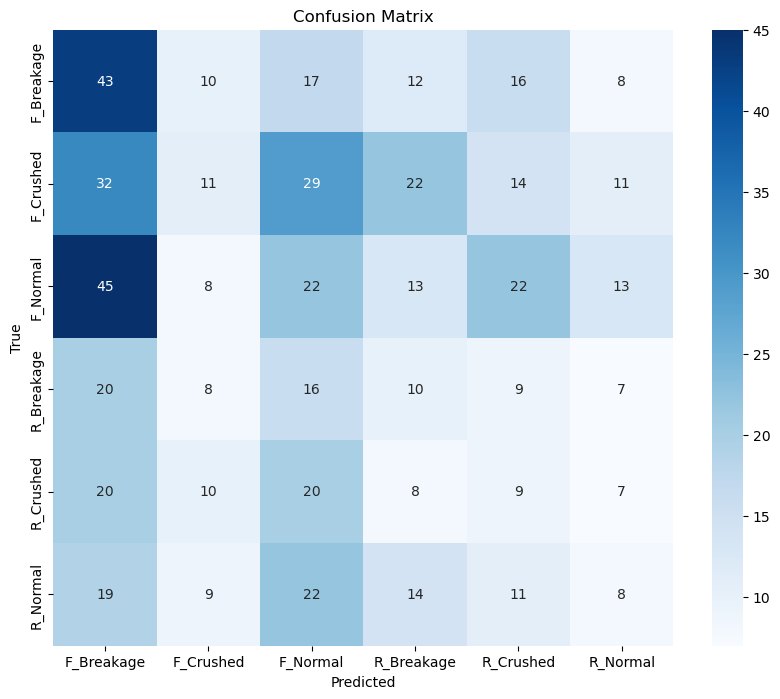

In [94]:
from sklearn.metrics import classification_report
report = classification_report(
    all_labels,
    all_predictions,
    target_names=class_names,
    digits=4
)

print("Classification Report:")
print(report)

# Optional: Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [87]:
torch.save(model.state_dict(), 'saved_model.pth')